# Basic demonstration 

This notebook it intended to demonstrate some of the basic concepts in the new version of of the rompy code

- Separation of 'runtime' from 'config' - more on this later
- Modular
    - There are a number of core objects 
- Pydantic throughout
    - Strong typing
    - Clearly defined APIs
    - Built in validators
- Declaritive
    - The entire configuration to run the model is passed at intantiation. 
    - The core wrapper is a pycallable, making it play nicely with downstream workflow packages (e.g. airflow)
    - Can still be run proceduraly. 
- Separation of intake components. 
    - Common filters now available as a separate import. 
    - Data is provdided to the wrapper as large lazy datasets, and data selection is done based on runtime period and grid spatial extents
    - Substantially reduced the fricton to hook up a different dataset
    - Filters are still available to use in intake drivers where appropriate (e.g. where constructing nowcasts from many forecasts becomes memory prohibitive to do lazily)

In [1]:
# Set up notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import some core objects
from rompy.swan import SwanConfig, SwanDataGrid, SwanGrid
from rompy.core import TimeRange, ModelRun, BaseConfig, BaseGrid, RegularGrid, DatasetXarray
from rompy.swan.data import SwanDataGrid
import xarray as xr
import numpy as np
import tempfile
import os
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
ModelRun??

Init signature:
ModelRun(
    *,
    run_id: str = 'run_id',
    period: rompy.core.time.TimeRange = TimeRange(start=datetime.datetime(2020, 2, 21, 4, 0), end=datetime.datetime(2020, 2, 24, 4, 0), duration=datetime.timedelta(days=3), interval=datetime.timedelta(seconds=900), include_end=True),
    output_dir: str = 'simulations',
    config: rompy.core.config.BaseConfig = BaseConfig(model_type='base', template='/source/rompy/rompy/templates/base', checkout='main'),
) -> None
Source:        
class ModelRun(RompyBaseModel):
    """A base class for all models"""

    run_id: str = Field("run_id", description="The run id")
    period: TimeRange = Field(
        TimeRange(
            start=datetime(2020, 2, 21, 4),
            end=datetime(2020, 2, 24, 4),
            interval="15M",
        ),
        description="The time period to run the model",
    )
    output_dir: str = Field("simulations", description="The output directory")
    config: BaseConfig = Field(
        BaseConfig(), des

In [4]:
TimeRange??

Init signature:
TimeRange(
    *,
    start: Optional[datetime.datetime] = None,
    end: Optional[datetime.datetime] = None,
    duration: Union[str, datetime.timedelta, NoneType] = None,
    interval: Union[str, datetime.timedelta, NoneType] = '1h',
    include_end: bool = True,
) -> None
Source:        
class TimeRange(BaseModel):
    """
    A time range object

    Examples
    --------
    >>> from rompy import TimeRange
    >>> tr = TimeRange(start="2020-01-01", end="2020-01-02")
    >>> tr
    TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=None, interval=None, include_end=True)
    >>> tr = TimeRange(start="2020-01-01", duration="1d")
    >>> tr
    TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=timedelta(days=1), interval=None, include_end=True)
    >>> tr = TimeRange(start="2020-01-01", duration="1d", interval="1h")
    >>> tr
    TimeRange(start=datetime.datetime(2

In [5]:
BaseConfig??

Init signature:
BaseConfig(
    *,
    model_type: Literal['base'] = 'base',
    template: Optional[str] = '/source/rompy/rompy/templates/base',
    checkout: Optional[str] = 'main',
    **extra_data: Any,
) -> None
Source:        
class BaseConfig(RompyBaseModel):
    """A base class for all templates"""

    model_type: Literal["base"] = "base"
    template: Optional[str] = Field(
        description="The path to the model template",
        default=DEFAULT_TEMPLATE,
    )
    checkout: Optional[str] = Field(
        description="The git branch to use if the template is a git repo",
        default="main",
    )

    class Config:
        extra = "allow"
File:           /source/rompy/rompy/core/config.py
Type:           ModelMetaclass
Subclasses:     SwanConfig, SwanConfigPydantic

In [6]:
BaseGrid??

Init signature:
BaseGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['base'] = 'base',
) -> None
Source:        
class BaseGrid(RompyBaseModel):
    """
    An object which provides an abstract representation of a grid in some geographic space

    This is the base class for all Grid objects. The minimum representation of a grid are two
    NumPy array's representing the vertices or nodes of some structured or unstructured grid,
    its bounding box and a boundary polygon. No knowledge of the grid connectivity is expected.
    """

    x: Optional[NDArray] = Field(description="A 1D array of x coordinates")
    y: Optional[NDArray] = Field(description="A 1D array of y coordinates")
    grid_type: Literal["base"] = "base"

    @property
    def minx(self) -> float:
        return np.nanmin(self.x)

    @property
    def maxx(self) -> float:
        return np.nanmax(self.x)



In [7]:
RegularGrid??

Init signature:
RegularGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['regular'] = 'regular',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
) -> None
Source:        
class RegularGrid(BaseGrid):
    """
    An object which provides an abstract representation of a regular grid in
    some geographic space
    """

    grid_type: Literal["regular"] = Field(
        "regular", description="Type of grid, must be 'regular'"
    )
    x0: Optional[float] = Field(None, description="X coordinate of the grid origin")
    y0: Optional[float] = Field(None, description="Y coordinate of the grid origin")
    rot: Optional[float] = Field(
        0.0, description="Rotation angle of the grid in degrees"
    )
    d

In [8]:
from rompy.swan import SwanDataGrid, SwanGrid, SwanConfig

In [9]:
SwanGrid??


Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Source:        
class SwanGrid(RegularGrid):
    """
    An object which provides an abstract representation of a regular SWAN
    grid in some geographic space
    """

    grid_type: Literal["REG"] = Field(
        "REG", description="Type of grid (REG=regular, CURV=curvilinear)"
    )
    exc: Optional[float] = Field(None, description="Missing value")
    gridfile: Optional[str] = Field(
        None, description="Name of grid file to load", max_length=100
    )

In [10]:
SwanConfig??

Init signature:
SwanConfig(
    *,
    model_type: Literal['swan'] = 'swan',
    template: str = '/source/rompy/rompy/templates/swan',
    checkout: Optional[str] = 'main',
    grid: rompy.swan.grid.SwanGrid,
    spectral_resolution: rompy.swan.config.SwanSpectrum = SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36),
    forcing: rompy.swan.config.ForcingData = ForcingData(bottom=None, wind=None, current=None, boundary=None),
    physics: rompy.swan.config.SwanPhysics = SwanPhysics(friction='MAD', friction_coeff=0.1),
    outputs: rompy.swan.config.Outputs = Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
)),
    spectra_file: str = 'boundary.spec',
    **extra_data: Any,
) -> None
Source:        
class SwanConfig(BaseConfig):
    """SWAN configuration"""

    grid: SwanGrid = Field(description="The model grid for the SWAN run")
    model_type: Literal["swan"] = F

In [11]:
from rompy.swan.config import SwanSpectrum, ForcingData, SwanPhysics, Outputs, SwanDataGrid

In [12]:
SwanSpectrum??

Init signature:
SwanSpectrum(
    *,
    fmin: float = 0.0464,
    fmax: float = 1.0,
    nfreqs: int = 31,
    ndirs: int = 36,
) -> None
Source:        
class SwanSpectrum(Spectrum):
    """SWAN Spectrum"""

    @property
    def cmd(self):
        return f"CIRCLE {self.ndirs} {self.fmin} {self.fmax} {self.nfreqs}"
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [13]:
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset."""

    z1: str = Field(
        description="Scaler paramater u componet of vecotr field",
        default=None,
    )
    z2: str = Field(description="v componet of vecotr field",
                    type=str, default=None)
    var: str = Field(
        description="SWAN variable name (WIND, BOTTOM, CURRENT)",
        default="WIND",
    )

    # root validator
    @root_validator
    def ensure_z1_in_da

In [14]:
SwanPhysics??

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Source:        
class SwanPhysics(RompyBaseModel):
    """Container class represting configuraable SWAN physics options"""

    friction: str = Field(
        default="MAD", description="The type of friction, either 'MAD' or 'TODO'."
    )
    friction_coeff: float = Field(
        default=0.1,
        description="The coefficient of friction for the given surface and object.",
    )

    @validator("friction")
    def validate_friction(cls, v):
        if v not in ["MAD", "OTHER", "ANDANOTHER"]:
            raise ValueError(
                "friction must be one of MAD, OTHER or ANDANOTHER"
            )  # TODO Raf to add actual friction options
        return v

    @validator("friction_coeff")
    def validate_friction_coeff(cls, v):
        # TODO Raf to add sensible friction coeff range
        if float(v) > 1:
            raise ValueError("friction_coeff must be less than 1")
        if fl

In [15]:
ForcingData??

Init signature:
ForcingData(
    *,
    bottom: rompy.swan.data.SwanDataGrid | None = None,
    wind: rompy.swan.data.SwanDataGrid | None = None,
    current: rompy.swan.data.SwanDataGrid | None = None,
    boundary: rompy.swan.boundary.DataBoundary | None = None,
) -> None
Source:        
class ForcingData(RompyBaseModel):
    bottom: SwanDataGrid | None = Field(
        None, description="Bathymetry data for SWAN"
    )  # TODO Raf should probably be required?
    wind: SwanDataGrid | None = Field(
        None, description="The wind data for SWAN.")
    current: SwanDataGrid | None = Field(
        None, description="The current data for SWAN.")
    boundary: DataBoundary | None = Field(
        None, description="The boundary data for SWAN."
    )

    def get(self, grid, runtime):
        forcing = []
        boundary = []
        for source in self:
            if source[1]:
                logger.info(f"\t Processing {source[0]} forcing")
                source[1]._filter_grid(g

In [16]:
SwanGrid??

Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Source:        
class SwanGrid(RegularGrid):
    """
    An object which provides an abstract representation of a regular SWAN
    grid in some geographic space
    """

    grid_type: Literal["REG"] = Field(
        "REG", description="Type of grid (REG=regular, CURV=curvilinear)"
    )
    exc: Optional[float] = Field(None, description="Missing value")
    gridfile: Optional[str] = Field(
        None, description="Name of grid file to load", max_length=100
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

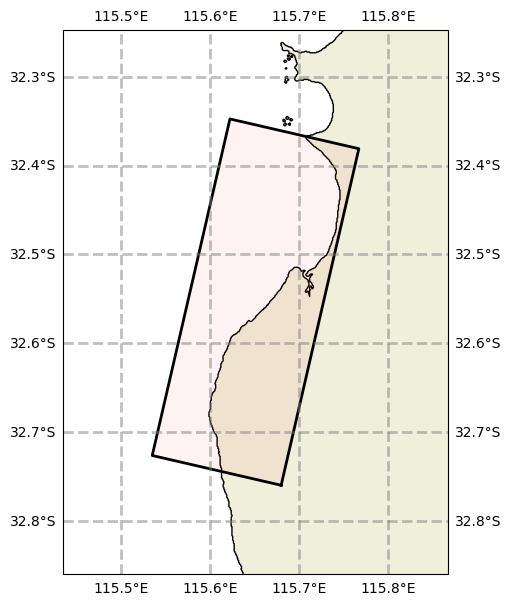

In [17]:
# Lets start by intantiaing a Swan grid

grid = SwanGrid(x0=115.68, y0=-32.76, dx=0.001, dy=0.001, nx=390, ny=150, rot=77)
grid.plot()

In [18]:
# Now lets look at how we might use that grid to define some data inputs
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset."""

    z1: str = Field(
        description="Scaler paramater u componet of vecotr field",
        default=None,
    )
    z2: str = Field(description="v componet of vecotr field",
                    type=str, default=None)
    var: str = Field(
        description="SWAN variable name (WIND, BOTTOM, CURRENT)",
        default="WIND",
    )

    # root validator
    @root_validator
    def ensure_z1_in_da

In [36]:
# Here we are creting some dummy data here to use as a bathymetry input
from rompy.swan import SwanDataGrid,  DataBoundary
os.makedirs("simulations/test_swantemplate/datasets", exist_ok=True)
datagrid = SwanGrid(x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.01, dy=0.01, exc=-99.0)

def nc_bathy(bottom=datagrid):
    # touch temp netcdf file
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "bathy.nc")
    bbox = bottom.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], bottom.dy)
    lon = np.arange(bbox[0], bbox[2], bottom.dx)
    ds = xr.Dataset(
        {
            "depth": xr.DataArray(
                np.random.rand(lat.size, lon.size),
                dims=["lat", "lon"],
                coords={"lat": lat, "lon": lon},
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return SwanDataGrid(
        id="bottom", dataset=DatasetXarray(uri=source), z1="depth", var="BOTTOM", latname="lat", lonname="lon"
    )

# and same again for wind
def nc_data_source(wind_grid=datagrid):
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "wind_inputs.nc")

    bbox = wind_grid.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], wind_grid.dy)
    lon = np.arange(bbox[0], bbox[2], wind_grid.dx)
    time = pd.date_range("2020-2-21", periods=10)

    ds = xr.Dataset(
        {
            "u": xr.DataArray(
                np.random.rand(10, lat.size, lon.size),
                dims=["time", "lat", "lon"],
                coords={
                    "time": time,
                    "lat": lat,
                    "lon": lon,
                },
            ),
            "v": xr.DataArray(
                np.random.rand(10, lat.size, lon.size),
                dims=["time", "lat", "lon"],
                coords={
                    "time": time,
                    "lat": lat,
                    "lon": lon,
                },
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return SwanDataGrid(id="wind", var="WIND", dataset=DatasetXarray(uri=source), z1="u", z2="v")

TypeError: descriptor '_x0' for 'RegularGrid' objects doesn't apply to a 'SwanGrid' object

(<Figure size 1000x1415.7 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

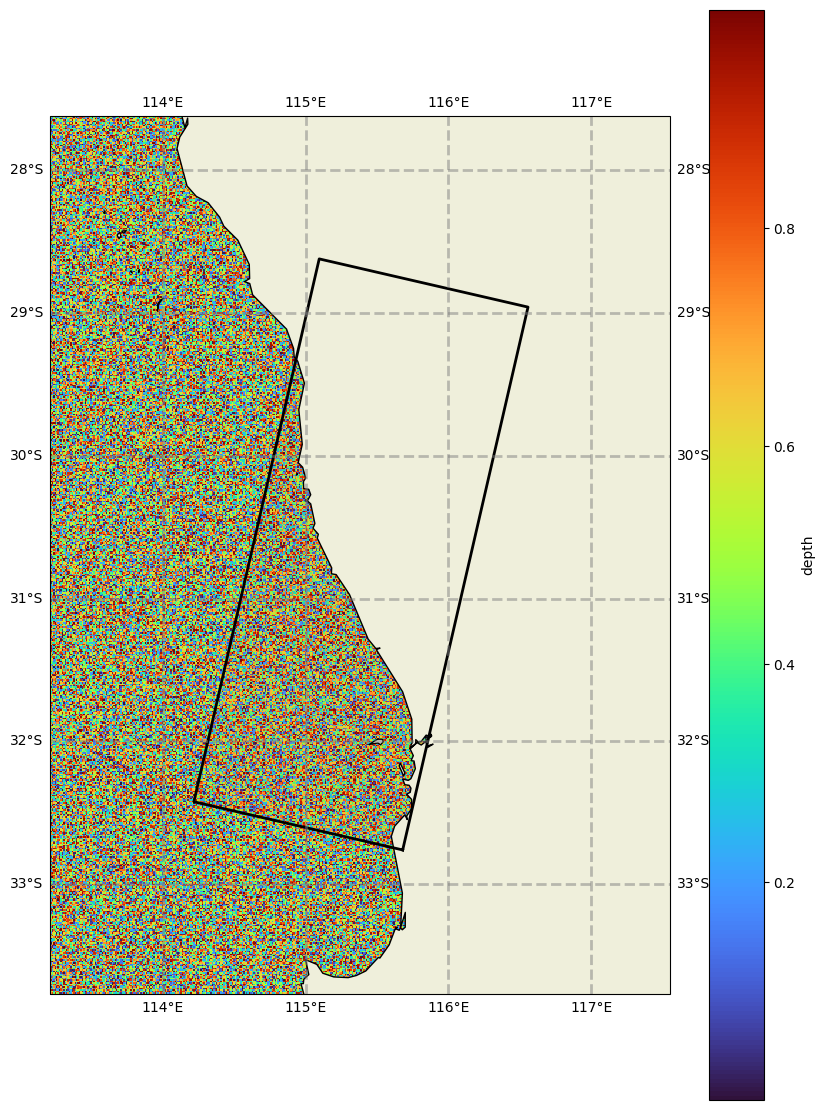

In [20]:
bathy = nc_bathy()
bathy.plot(param='depth', fscale=10, model_grid=datagrid)


In [21]:
# retrive the bathy data
bathy.get('./')

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: ./bottom.grd


"INPGRID BOTTOM REG 113.21844490282216 -33.76 0.0 433 613 0.010000000000005116 0.00999999999999801 EXC -99.0\nREADINP BOTTOM 1.0 'bottom.grd' 3 FREE\n"

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: ./bottom.grd


(<Figure size 1000x1707.51 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

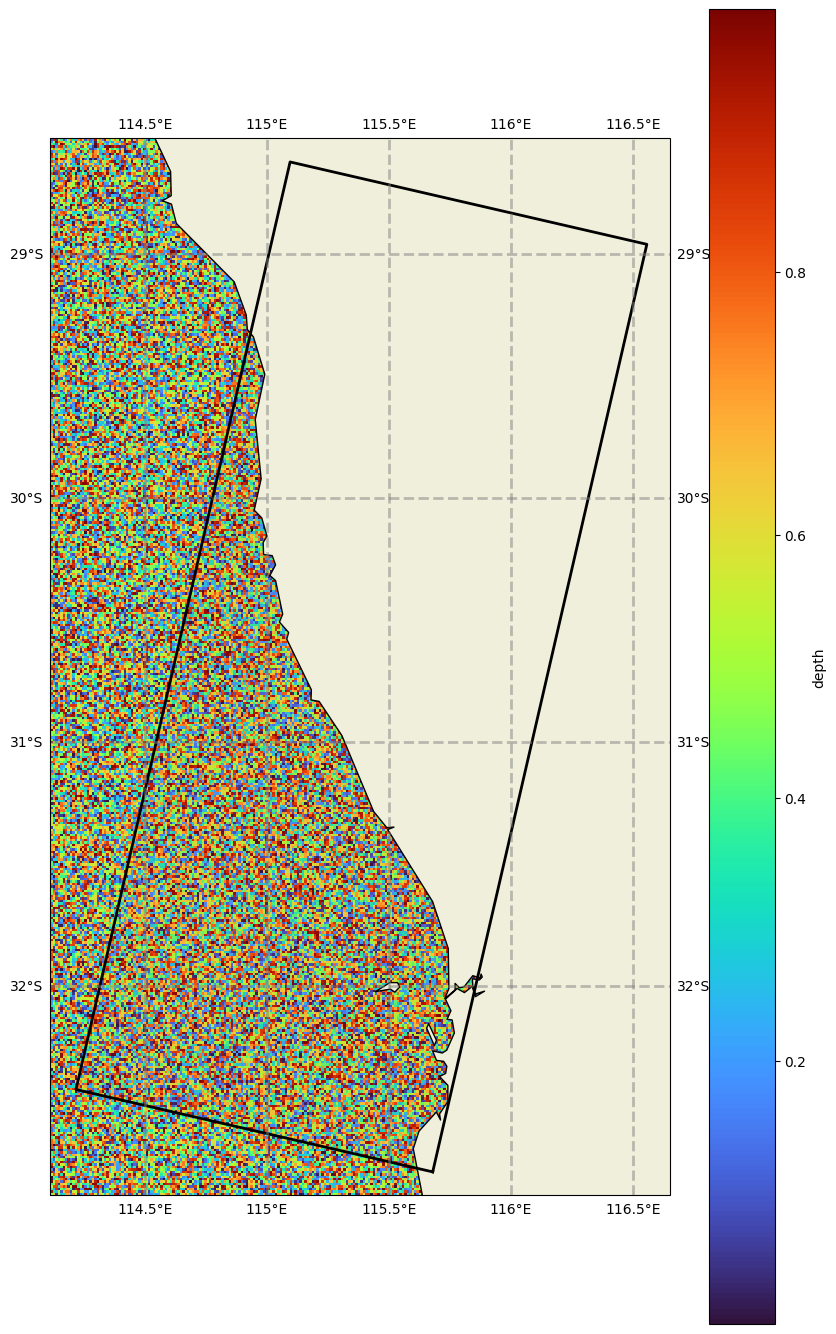

In [22]:
# But instead of just using the data as is, we can use the grid to subset in time and space

bathy._filter_grid(datagrid)
bathy.get('./')
bathy.plot(param='depth', fscale=10, model_grid=datagrid)

# This is what is done internally in the wrapper allowing us to use lazy grids without doing any filtering, and have the
# wrapper use only what it needs

In [23]:
# retive the wind data
wind = nc_data_source()
wind.get('./')

INFO:rompy.swan.data:	Writing wind to ./wind.grd


"INPGRID WIND REG 113.21844490282216 -33.76 0.0 433 613 0.010000000000005116 0.00999999999999801 NONSTATION 20200221.000000 24.0 HR\nREADINP WIND 1 'wind.grd' 3 0 1 0 FREE\n"

In [38]:
# Similarly, we can use the DataBoundary object to filter boundary data
# First lets have a look at teh boundary object
DataBoundary??



Init signature:
DataBoundary(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake | rompy.swan.boundary.DatasetWavespectra,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    spacing: Optional[float] = None,
    sel_method: Literal['idw', 'nearest'] = 'idw',
    tolerance: rompy.swan.boundary.ConstrainedFloatValue = 1.0,
    rectangle: Literal['closed', 'open'] = 'closed',
) -> None
Source:        
class DataBoundary(DataGrid):
    """SWAN BOUNDNEST1 NEST data class.

    Notes
    -----
    The `tolerance` behaves differently with sel_methods `idw` and `nearest`; in `idw`
    sites with no enough neighbours within `tolerance` are masked whereas in `nearest`
    an exception is raised (see wavespectra document

In [41]:
# Here we use a test boundary dataset
bnd = DataBoundary(id='bnd', dataset=DatasetXarray(uri="../tests/data/aus-20230101.nc"))
bnd.plot()

TypeError: DataGrid.plot() missing 1 required positional argument: 'param'

In [40]:
# Putting these together we can create a swan forcing object. This object will loop over all the data source, filter in time and space to match the model run, 
# write the data to the scratch space, and produce the required control file inputs for swan
forcing = ForcingData(wind=wind, bottom=bathy)
forcing.get??

Signature: forcing.get(grid, runtime)
Docstring: <no docstring>
Source:   
    def get(self, grid, runtime):
        forcing = []
        boundary = []
        for source in self:
            if source[1]:
                logger.info(f"\t Processing {source[0]} forcing")
                source[1]._filter_grid(grid)
                source[1]._filter_time(runtime.period)
                if source[0] == "boundary":
                    boundary.append(source[1].get(runtime.staging_dir, grid))
                else:
                    forcing.append(source[1].get(runtime.staging_dir, grid))
        return dict(forcing="\n".join(forcing), boundary="\n".join(boundary))
File:      /source/rompy/rompy/swan/config.py
Type:      method

In [25]:
try:
    physics = SwanPhysics(friction='INVALID')
except ValueError as e:
    logger.warning(e)

friction
  friction must be one of MAD, OTHER or ANDANOTHER (type=value_error)


In [26]:
physics = SwanPhysics()
print(physics.cmd)

GEN3 WESTH 0.000075 0.00175
BREAKING
FRICTION MAD 0.1

TRIADS

PROP BSBT
NUM ACCUR 0.02 0.02 0.02 95 NONSTAT 20



In [27]:
Outputs??

Init signature:
Outputs(
    *,
    grid: rompy.swan.config.GridOutput = GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']),
    spec: rompy.swan.config.SpecOutput = SpecOutput(period=None, locations=OutputLocs
),
) -> None
Source:        
class Outputs(RompyBaseModel):
    """Outputs for SWAN"""

    grid: GridOutput = GridOutput()
    spec: SpecOutput = SpecOutput()
    _datefmt: str = "%Y%m%d.%H%M%S"

    @property
    def cmd(self):
        out_intvl = "1.0 HR"  # Hardcoded for now, need to get from time object too TODO
        ret = "OUTPUT OPTIONS BLOCK 8\n"
        ret += f"BLOCK 'COMPGRID' HEADER 'outputs/swan_out.nc' LAYOUT 1 {' '.join(self.grid.variables)} OUT {self.grid.period.start.strftime(self._datefmt)} {out_intvl}\n"
        ret += "\n"
        if self.spec.locations:
            ret += f"POINTs 'pts' FILE 'out.loc'\n"
        ret += f"SPECout 'pts' SPEC2D ABS 'outputs/spec_out.nc' OUTPUT {self.spec.period.start.strftim

In [28]:
outputs = Outputs()
outputs
# outputs.cmd

Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
))

In [29]:
# Lets now put those components into a swan config object and instantiate a model run

run = ModelRun(
        run_id="test_swantemplate",
        period=TimeRange(start=datetime(2020, 2, 21, 4), end=datetime(2020, 2, 24, 4)),
        output_dir="simulations",
        config=SwanConfig(
            grid=grid,
            physics=physics,
            forcing=forcing,
            outputs=outputs,
        )
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

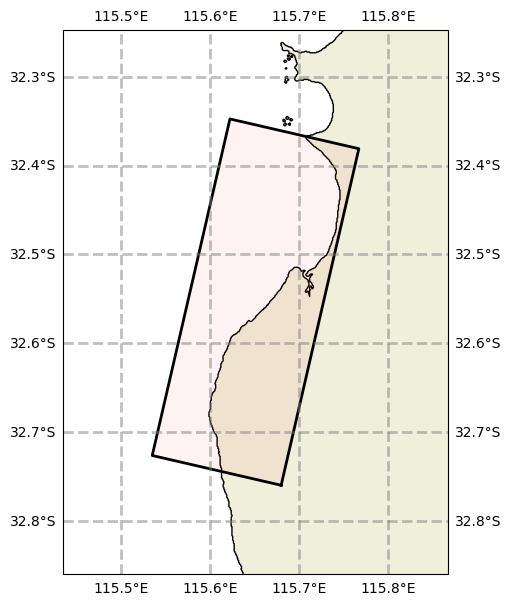

In [30]:
# This grid object is still accessible as before, but the path has changed slightly
run.config.grid.plot()

In [32]:
run.config.forcing.get(grid=run.config.grid, runtime=run)

INFO:rompy.swan.config:	 Processing bottom forcing
INFO:rompy.swan.data:	Writing bottom to simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.config:	 Processing wind forcing
INFO:rompy.swan.data:	Writing wind to simulations/test_swantemplate/wind.grd


{'forcing': "INPGRID BOTTOM REG 115.43844490282329 -32.85000000000018 0.0 42 60 0.010000000000005116 0.00999999999999801 EXC -99.0\nREADINP BOTTOM 1.0 'bottom.grd' 3 FREE\n\nINPGRID WIND REG 115.68 -32.76 77.0 389 149 0.001 0.001 NONSTATION 20200222.000000 24.0 HR\nREADINP WIND 1 'wind.grd' 3 0 1 0 FREE\n",
 'boundary': ''}

In [33]:
run.config.outputs.spec.locations

OutputLocs

In [34]:
run()

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: grid: SwanGrid: REG, 390x150
spectral_resolution: fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: bottom=SwanDataGrid(id='bottom', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/bathy.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={'lon': slice(115.43481886034701, 115.86750596013977, None), 'lat': slice(-32.86, -32.247452337701304, None), 'time': slice(datetime.datetime(2020, 2, 21, 4, 0), datetime.datetime(2020, 2, 24, 4, 0), None)}, timenorm={}, rename={}, derived={}), variables=['depth'], latname='lat', lonname='lon', timename='time', z1='depth', z2=None, var='BOTTOM') wind=SwanDataGrid(id='wind', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/wind_inputs.nc', engine=Non

'/source/rompy/notebooks/simulations/test_swantemplate'

In [35]:
run.config.forcing.bottom.path

AttributeError: 'SwanDataGrid' object has no attribute 'path'

# Command line interface

Another advantage of using a declaritive model is that configuration becomes much easier to manage. For example, the run that was componsed procedurally above can be fully described in configuration. 

eg. 

```yaml
!include demo.yml

In [ ]:
!cat demo.yml

# Note that this is config fully replicates the config deomonstrated in the demo notebook,
# however it requireds the datasets created in that notebook to work. 

run_id: test_swantemplate 
period:
  start: 20200221T04
  # end: 20200224T04
  duration: 3d
  interval: 1h
output_dir: simulations
config:
  grid:
    x0: 115.68
    y0: -32.76
    rot: 77.0
    dx: 0.001
    dy: 0.001
    nx: 390
    ny: 150
    gridtype: REG
  spectral_resolution:
    fmin: 0.0464
    fmax: 1.0
    nfreqs: 31
    ndirs: 36
  forcing:
    wind:
      model_type: swan
      id: wind 
      var: WIND 
      dataset: 
        uri: simulations/test_swantemplate/datasets/wind_inputs.nc
        model_type: xarray
      z1: u
      z2: v
      latname: lat
      lonname: lon
    bottom: 
      id: bottom
      var: BOTTOM
      dataset: 
        uri: simulations/test_swantemplate/datasets/bathy.nc
        model_type: xarray
      z1: depth
      latname: lat
      lonname: lon
  physics': 
    friction: MAD
    fri

In [ ]:
# initantiating a model run using this config
import yaml
config = yaml.load(open('demo.yml', 'r'), Loader=yaml.FullLoader)

# This is a little hacky - need to fix this
configObs = SwanConfig(**config.pop('config'))
run = ModelRun(**config, config=configObs)

# and then calling as before
run()

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: grid: SwanGrid: REG, 390x150
spectral_resolution: fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: bottom=SwanDataGrid(id='bottom', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/bathy.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['depth'], latname='lat', lonname='lon', timename='time', z1='depth', z2=None, var='BOTTOM') wind=SwanDataGrid(id='wind', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/wind_inputs.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['u', 'v'], latname='lat', lonname='lon', timename='time', z1='u', z2='v', var='WIND') current=None

FileNotFoundError: [Errno 2] No such file or directory: '/source/rompy/notebooks/simulations/test_swantemplate/datasets/bathy.nc'

In [ ]:
# There is also a command line interface to run defined model configurations

!rompy --help

Usage: rompy [OPTIONS] {base|swan} CONFIG

  Run model Usage: rompy <model> config.yml Args:     model(str): model type
  config(str): yaml config file

Options:
  -k, --kwargs TEXT  additional key value pairs in the format key:value
  --help             Show this message and exit.


In [ ]:
!rompy swan demo.yml

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: model_type='base' template='/source/rompy/rompy/templates/base' checkout='main' config=SwanConfig(model_type='swan', template='/source/rompy/rompy/templates/swan', checkout='main', grid=SwanGrid: REG, 390x150, spectral_resolution=SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36), forcing=ForcingData(bottom=SwanDataGrid(id='bottom', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/bathy.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['depth'], latname='lat', lonname='lon', timename='time', z1='depth', z2=None, var='BOTTOM'), wind=SwanDataGrid(id='wind', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/wind_inputs.nc', engi